# Face Recognition

## Set up

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the lab materials
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Lab materials 01-20210104'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CV_CW' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['CW_Dataset.zip', 'Project']


In [ ]:
!pip install opencv-python==4.4.0.46

In [ ]:
%cd /content
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset.zip

/content


In [ ]:
import cv2
import time
from PIL import Image
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, train_test_split, learning_curve
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from skimage.feature import hog
from skimage import data, exposure
from sklearn import svm
import numpy as np
from collections import Counter
from sklearn.neural_network import MLPClassifier
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import seaborn as sns
import random
import pickle

from scipy.stats import zscore
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import recall_score, roc_auc_score, precision_score, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set()
rc = {'axes.facecolor': 'white',
      'axes.edgecolor': 'black',
      'axes.labelsize' : '24',
      'axes.titlesize' : '24',
      'font.family': ['serif'], 
      'grid.color': 'gainsboro',
      'xtick.color': '#333F4B',
      'font.size': '20',
      'ytick.color': '#333F4B',
      'grid.linestyle': '-', 
      'patch.edgecolor': 'none',
      'axes.grid' : 'False'
      }
sns.set_style(rc=rc)
sns.set_context("notebook", font_scale=1.5)
colors = ['dimgray','mediumaquamarine', 'goldenrod',  'plum' , 'indianred', 'cornflowerblue', 'lightsalmon' ]

## Import Data

In [ ]:
def import_data(path):
  files = [file for file in sorted(os.listdir(path)) if file.endswith('.jpg')]
  images = [cv2.imread(os.path.join(path, file)) for file in files]
  f = open("labels/list_label_" + path + ".txt", "r")
  labels = [row.split(' ')[1][0] for row in f]
  
  return images, labels

In [ ]:
X_train, y_train = import_data("train")

In [ ]:
X_test, y_test = import_data("test")

## SVM with SIFT

**Apply SIFT feature descriptor on images**

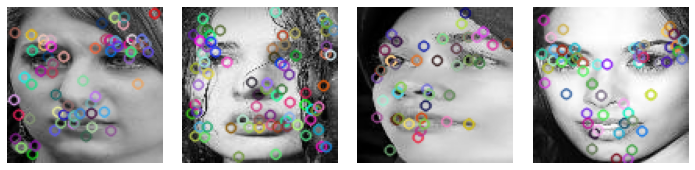

In [ ]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

# Create empty lists for feature descriptors and labels
des_list = []
y_train_list = []

fig, ax = plt.subplots(1, 4, figsize=(10, 8), sharey=True)

for i in range(len(X_train)):
    # Identify keypoints and extract descriptors with SIFT
    img = img_as_ubyte(color.rgb2gray(X_train[i]))
    kp, des = sift.detectAndCompute(img, None)

    # Show results for first 4 images
    if i<4:
        img_with_SIFT = cv2.drawKeypoints(img, kp, img)
        ax[i].imshow(img_with_SIFT)
        ax[i].set_axis_off()

    # Append list of descriptors and label to respective lists
    if des is not None:
        des_list.append(des)
        y_train_list.append(y_train[i])

fig.tight_layout()
plt.show()

# Convert to array for easier handling
des_array = np.vstack(des_list)

In [ ]:
# Number of centroids/codewords: good rule of thumb is 10*num_classes
k = len(np.unique(y_train)) * 10


batch_size = des_array.shape[0] // 4
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size).fit(des_array)

In [ ]:
# Convert descriptors into histograms of codewords for each image
hist_list = []
idx_list = []

for des in des_list:
    hist = np.zeros(k)

    idx = kmeans.predict(des)
    idx_list.append(idx)
    for j in idx:
        hist[j] = hist[j] + (1 / len(des))
    hist_list.append(hist)

hit_array = np.vstack(hist_list)

**Initialisation of SVM classifier with its parameters**

In [ ]:
# Create a classifier: a support vector classifier
svm_parameters =[
                 {"kernel":["linear", "poly", "rbf"], "C" : [1, 10 ,100]}]


classifier = SVC(kernel = "rbf", C = 10)

# We learn the digits on the first half of the digits
classifier.fit(hit_array, y_train_list)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
hist_list = []

for i in range(len(X_test)):
    img = img_as_ubyte(color.rgb2gray(X_test[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)

        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        # hist = scale.transform(hist.reshape(1, -1))
        hist_list.append(hist)

    else:
        hist_list.append(None)

# Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
hist_list = [hist_list[i] for i in idx_not_empty]
y_test = [y_test[i] for i in idx_not_empty]
hist_array = np.vstack(hist_list)

In [ ]:
predicted = classifier.predict(hist_array).tolist()

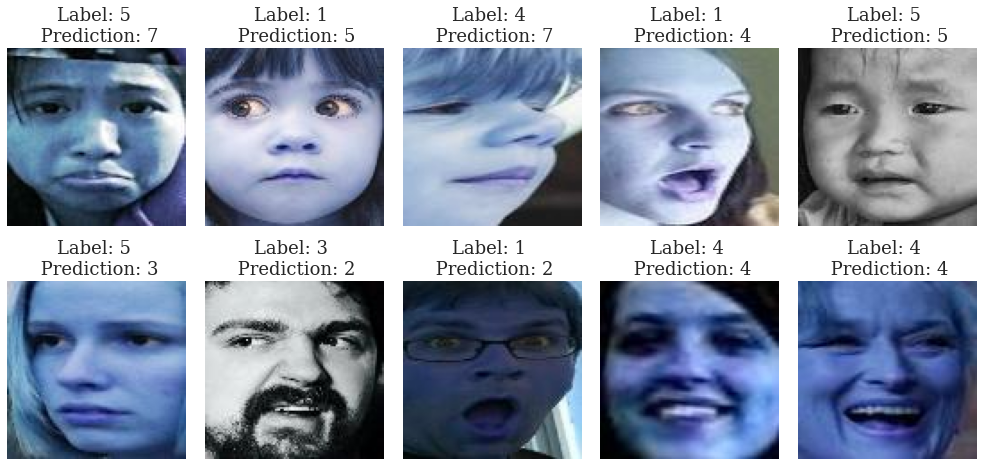

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_test[i])
    ax[i].set_title(f'Label: {y_test[i]} \n Prediction: {predicted[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [ ]:
print(f"""Classification report for classifier {classifier}:
      {metrics.classification_report(y_test, predicted)}\n""")

Classification report for classifier SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
                    precision    recall  f1-score   support

           1       0.24      0.21      0.22       329
           2       0.17      0.04      0.07        74
           3       0.10      0.04      0.05       160
           4       0.49      0.65      0.56      1183
           5       0.21      0.16      0.18       478
           6       0.22      0.12      0.15       161
           7       0.33      0.33      0.33       680

    accuracy                           0.38      3065
   macro avg       0.25      0.22      0.22      3065
weighted avg       0.34      0.38      0.35      3065




**Apply grid search with cross validation for hyperparametisation**

In [ ]:
param_grid = {'kernel':["linear", "poly", "rbf"], 'C': [0.1, 1, 10, 100, 1000], 'gamma':[1, 0.1, 0.01, 0.001]}
grid = GridSearchCV(SVC(), param_grid, verbose=3)

In [ ]:
grid.fit(hit_array, y_train_list)

In [ ]:
grid.best_params_

In [ ]:
grid.best_estimator_

**Saving model**

In [ ]:
with open("SVM_SIFT_with_hyperparameters_trained.pkl", mode ="ab") as f:
    pickle.dump(classifier, f)

In [ ]:
with open("SVM_SIFT_with_hyperparameters_trained.pkl", "rb") as f:
    SVM_trained = pickle.load(f)

In [ ]:
preds = SVM_trained.predict(hist_array).tolist()

In [ ]:
print(f"""Classification report for classifier {SVM_trained}:
      {metrics.classification_report(y_test, preds)}\n""")

## SVM with HOG

**Apply HOG on pictures**

In [ ]:
# Create empty lists for feature descriptors and labels
hog_images = []
hog_features = []
ppc = 16

for i in range(len(X_train)):
    # Identify keypoints and extract descriptors with SIFT
    img = img_as_ubyte(color.rgb2gray(X_train[i]))
    fd, hog_image = hog( img, orientations=8, pixels_per_cell=(16, 16),  cells_per_block=(1, 1), visualize=True)
    
    hog_images.append(hog_image)
    hog_features.append(fd)

<function matplotlib.pyplot.show>

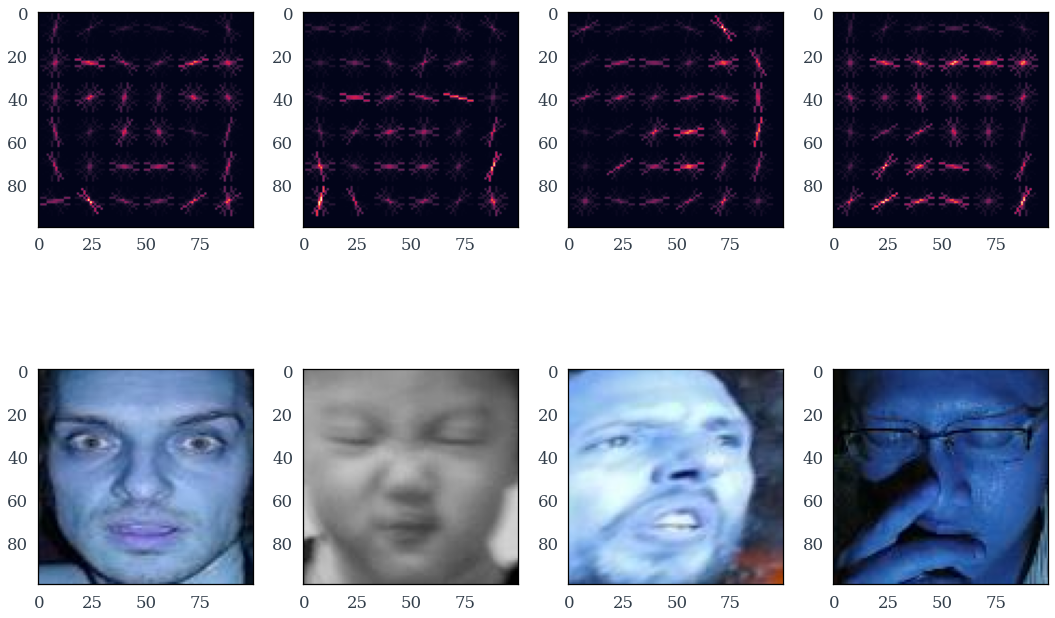

In [ ]:
plt.figure(figsize=(15, 11), linewidth=1)

for i in range(1,5):
  x = random.randint(1,10000)
  plt.subplot(2,4,i)
  plt.imshow(hog_images[x])
  plt.subplot(2,4,4+i)
  plt.imshow(X_train[x])
plt.tight_layout()
plt.show


# plt.figure(figsize=(14, 11), linewidth=1)

# for i in range(1,5):
#   plt.subplot(1,4,i)
#   plt.imshow(hog_images[random.randint(1,100)])

# plt.tight_layout()
# plt.show

**Initialise SVM classifier with its parameters**

In [ ]:
clf2 = SVC()

In [ ]:
hog_features = np.array(hog_features)

clf2.fit(hog_features, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
hist_list2 = []

for i in range(len(X_test)):
    img = img_as_ubyte(color.rgb2gray(X_test[i]))
    fd, hog_image = hog( img, orientations=8, pixels_per_cell=(16, 16),  cells_per_block=(1, 1), visualize=True)
    
    
    hist_list2.append(fd)

hist_array = np.vstack(hist_list2)

In [ ]:
y_pred = clf2.predict(hist_list2)

**Evaluating on test set**

<function matplotlib.pyplot.show>

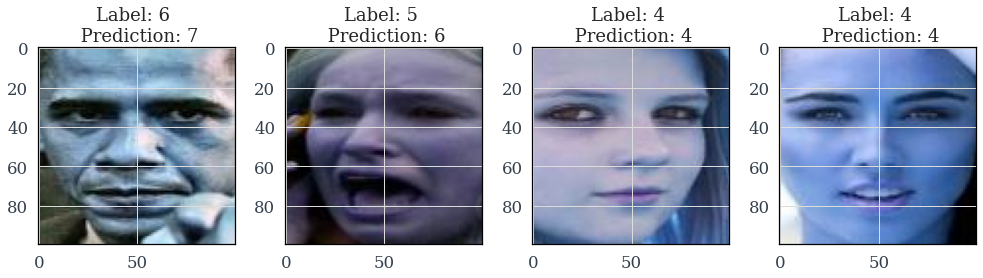

In [ ]:
plt.figure(figsize=(14, 11), linewidth=1)

for i in range(1,5):
  x = random.randint(1,100)
  plt.subplot(1,4,i)
  plt.imshow(X_test[x])
  plt.title(f'Label: {y_test[x]} \n Prediction: {y_pred[x]}')

plt.tight_layout()
plt.show

In [ ]:
print(f"""Classification report for classifier {clf2}:
      {metrics.classification_report(y_test, y_pred)}\n""")

Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
                    precision    recall  f1-score   support

           1       0.63      0.51      0.57       329
           2       0.91      0.14      0.24        74
           3       0.55      0.04      0.07       160
           4       0.72      0.88      0.79      1185
           5       0.52      0.44      0.48       478
           6       0.68      0.31      0.42       162
           7       0.57      0.71      0.63       680

    accuracy                           0.64      3068
   macro avg       0.65      0.43      0.46      3068
weighted avg       0.64      0.64      0.61      3068




**Apply grid search with cross validation for hyperparametisation**

In [ ]:
param_grid2 = {'kernel':["linear", "poly", "rbf"], 'C': [0.1, 1, 10, 100, 1000], 'gamma':[1, 0.1, 0.01, 0.001]}
grid2 = GridSearchCV(SVC(), param_grid2, verbose=3)

In [ ]:
grid2.fit(hog_features, y_train)

**Saving Model**

In [ ]:
with open("SVM_HOG_with_hyperparameters_trained.pkl", mode ="ab") as f:
    pickle.dump(clf2, f)

## MLP with HOG

**Initialising MLP classifier with its parameters**

In [ ]:
MLP_m = MLPClassifier(random_state=1, max_iter=300).fit(hog_features, y_train)

In [ ]:
mlp_pred = MLP_m.predict(hist_list2)

<function matplotlib.pyplot.show>

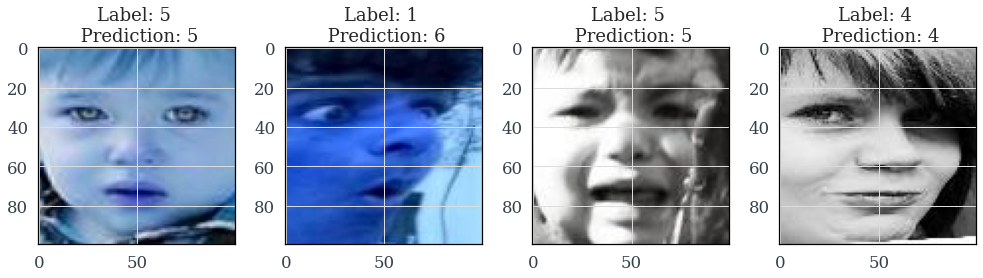

In [ ]:
plt.figure(figsize=(14, 11), linewidth=1)

for i in range(1,5):
  x = random.randint(1,100)
  plt.subplot(1,4,i)
  plt.imshow(X_test[x])
  plt.title(f'Label: {y_test[x]} \n Prediction: {mlp_pred[x]}')

plt.tight_layout()
plt.show

In [ ]:
print(f"""Classification report for classifier {MLP_m}:
      {metrics.classification_report(y_test, mlp_pred)}\n""")

Classification report for classifier MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False):
                    precision    recall  f1-score   support

           1       0.54      0.49      0.51       329
           2       0.38      0.31      0.34        74
           3       0.25      0.19      0.21       160
           4       0.73      0.84      0.78      1185
           5       0.49      0.47      0.48       478
           6       0.48      0.34      0.40       162
           7       0.58      0.57      0.58       680


**Apply grid search with cross validation for hyperparametisation**

In [ ]:
parameters={'solver': ['lbfgs', 'sgd', 'adam'], 'activation': ['identity', 'logistic', 'tanh', 'relu']}
mpl_hyper =GridSearchCV(MLPClassifier(random_state=1, max_iter=5000, hidden_layer_sizes=(3,3), alpha=1e-5), parameters, n_jobs=-1, cv=10)

In [ ]:
mpl_hyper.fit(hog_features, y_train)

In [ ]:
mpl_hyper.best_params_

In [ ]:
mlp_preds = mpl_hyper.predict(hist_list2)

In [ ]:
print(f"""Classification report for classifier {mpl_hyper}:
      {metrics.classification_report(y_test, mlp_preds)}\n""")

**Saving model**

In [ ]:
with open("MLP_with_hyperparameters_trained.pkl", mode ="ab") as f:
    pickle.dump(MLP_m, f)